# Life Expectancy and GDP Analysis
*By [Sergio Avalos S.](https://github.com/srg2912)*

In this project, we aim to explore this dataset using libraries like pandas, matplotlib and seaborn. The specific goals we aim to achieve are:

 - Analyze the correlation between GDP and life expectancy – Determine whether wealthier countries tend to have longer life expectancy.
 - Identify trends over time – See how GDP and life expectancy have evolved globally or for specific countries.
 - Predict life expectancy – Use regression models to predict life expectancy based on GDP.
 - Detect anomalies – Find countries with unexpectedly high or low life expectancy relative to their GDP.  

### 1. Data Understanding and Cleaning


First, we need to import the libraries we'll use alongside the dataset we'll be using. We'll also be checking for any missing values.

In [1]:
# Importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats

# Importing Dataset as df
df = pd.read_csv('all_data.csv')

Now that we've created our new DataFrame df, we'll check the first five rows and additional information related to the DataFrame.

In [ ]:
# Inspects first five rows and additional information of the variables
print(df.head())
print(df.info())

The columns of our DataFrame are 'Country', 'Year', 'Life expectancy at birth (years)' and 'GDP'. There are no null values and, originally, the variable Country has an object type, and the variable Year has an integer type. We'll change the type of Country to string, since it's a nominal variable, but we'll also change the type of the Year variable to Object, since it's an ordinal variable.

In [ ]:
# Convert data types 
df.Country = df.Country.astype('string')
df.Year = df.Year.astype('object')

# Print new data types
print(df.dtypes) 

# Print the years we have on our DataFrame
print(df.Year.unique())

Since we have data from the year 2000 to the year 2015, we'll transform now Year into an ordinal variable using the Panda's Categorical method.

In [ ]:
# Transforms Year into an ordinal variable
order_list = [i for i in df.Year.unique()]
df.Year = pd.Categorical(df.Year, order_list, ordered=True)

# Prints the result
print(df.Year.unique())

To ensure we don't have any missing data or any outliers, we'll print all of the unique values of Country, and we'll create histograms for the numerical variables.

In [ ]:
# Print all the unique values of Country:
print(df.Country.unique())

In [ ]:
# Rename Life expectancy at birth (years) to Life_exp for practical reasons
df.rename(columns={'Life expectancy at birth (years)': 'Life_exp'}, inplace=True)

# Histogram for Life_exp:
sns.histplot(df.Life_exp)
plt.title('Count of Life Expectancty')
plt.xlabel('Life Expectancy (Years)')
plt.ylabel('Count')

plt.show()
plt.clf()

In [7]:
# Converting data into of GDP into Billion USD:
df.GDP = round(df.GDP / (10**9), 2)

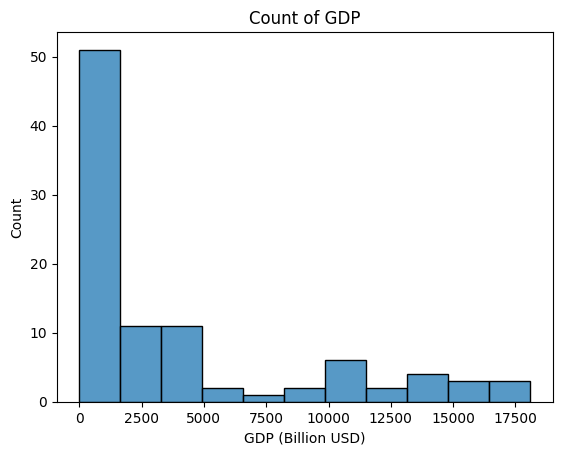

<Figure size 640x480 with 0 Axes>

In [23]:
# Histogram for GDP:
sns.histplot(df.GDP)
plt.title('Count of GDP')
plt.xlabel('GDP (Billion USD)')
plt.ylabel('Count')

plt.show()
plt.clf()

Summary of changes we've made:
 - The Country variable didn't present any missing values, so no changes were made.
 - The Life expectancy at birth (years) variable name was changed to Life_exp for practical reasons, it didn't present any stange values like 0 or extremely high averages.
 - The GDP variable that was previously measured in USD now it's measured in Billion USD for practical reason, it presents a histogram highly skewed to the right. 

### 2. Exploratory Data Analysis (EDA)

In this section, we'll proceed with the Exploratory Data Analysis (EDA): We'll explore any how life expectancy and GDP vary across countries and time.

First, we will explore how Life Expectancy and GDP vary across time for different countries. Instead of using ANOVA, which assumes normality, we opted for line plots with hue='Country'. This approach allows us to visualize trends over time for each country individually, revealing important patterns that might be lost in a purely statistical comparison.

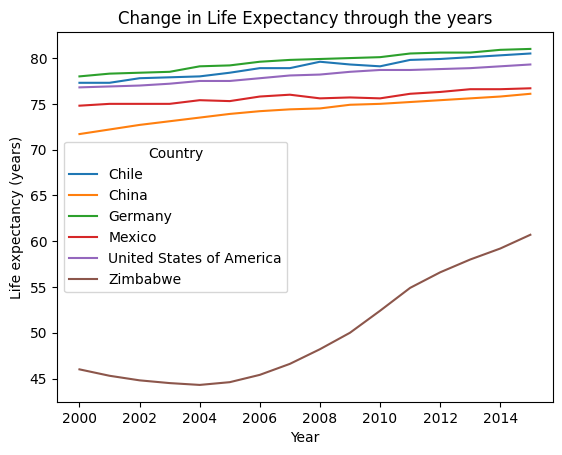

<Figure size 640x480 with 0 Axes>

In [9]:
# Lineplot for Life_exp vs Year
sns.lineplot(x='Year', y='Life_exp', hue='Country', data=df)
plt.xlabel('Year')
plt.ylabel('Life expectancy (years)')
plt.title('Change in Life Expectancy through the years')
plt.show()
plt.clf()

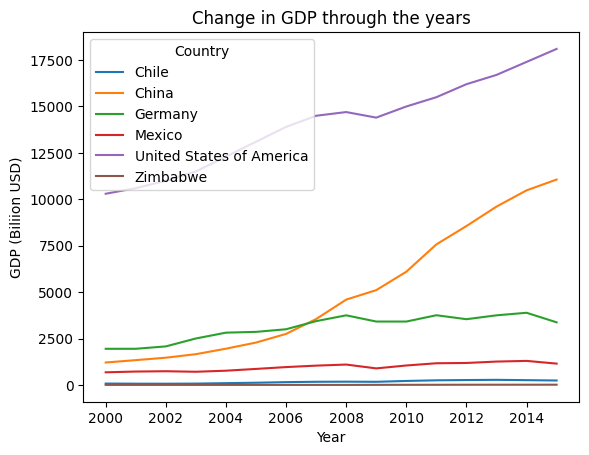

<Figure size 640x480 with 0 Axes>

In [10]:
# Lineplot for GDP vs Year
sns.lineplot(x='Year', y='GDP', hue='Country', data=df)
plt.xlabel('Year')
plt.ylabel('GDP (Biliion USD)')
plt.title('Change in GDP through the years')
plt.show()
plt.clf()

From our plots we can deduce that the country of Zimbabwe has consistently kept an extremely low life expectancy through the years, on the other hand, the United States of America has consistently kept an extremely high GDP and China has had a considerably increment on it's GDP ever since 2006, surpasing Germany, that has consistently kept a high GDP, on 2007.

To properly identify the outliers, we can use the IQR method. We'll start by identifying the outliers on the variable Life_exp:

In [ ]:
# Finding the 25th and 75th percentiles
percentile25_life = df['Life_exp'].quantile(0.25)
percentile75_life = df['Life_exp'].quantile(0.75)
iqr_life = percentile75_life - percentile25_life

# Define the outlier thresholds
lower_bound_life = percentile25_life - 1.5 * iqr_life
upper_bound_life = percentile75_life + 1.5 * iqr_life

# Identify outliers
outliers_life = df[(df['Life_exp'] < lower_bound_life) | (df['Life_exp'] > upper_bound_life)]

print(outliers_life)

Now that we have determined that Zimbabwe's values are outliers for the Life_exp variable. We'll find the outliers for the GDP variable:

In [ ]:
# Finding the 25th and 75th percentiles
percentile25_gdp = df['GDP'].quantile(0.25)
percentile75_gdp = df['GDP'].quantile(0.75)
iqr_gdp = percentile75_gdp - percentile25_gdp

# Define the outlier thresholds
lower_bound_gdp = percentile25_gdp - 1.5 * iqr_gdp
upper_bound_gdp = percentile75_gdp + 1.5 * iqr_gdp

# Identify outliers
outliers_gdp = df[(df['GDP'] < lower_bound_gdp) | (df['GDP'] > upper_bound_gdp)]

print(outliers_gdp)

We've determined that all of the values from the USA are outliers, but the values on the last 2 years of China's GDP are also outliers, to determine if China's growth over the last few years is significant, we can realize a Two Sample T-Test. First we need to ensure that our data has a normal distribution, in order to achieve that we try a log transformation: 

In [ ]:
# Create sample data
china_log = np.log(df.GDP[df.Country=='China'])
germany_log = np.log(df.GDP[df.Country=='Germany'])

#Plot histogram of GDP of China and Germany to show normal distribution
sns.histplot(np.log(df.GDP[(df.Country=='China')|(df.Country=='Germany')]))
plt.xlabel('GDP of China and Germany (Logarithmical)')
plt.show()
plt.clf()

In [ ]:
# Check for equal variances
levene_result = scipy.stats.levene(china_log, germany_log)
print("Levene's test result:", levene_result)

# Perform the t-test
if levene_result.pvalue > 0.05:
    t_stat, p_value = scipy.stats.ttest_ind(china_log, germany_log, equal_var=True)
else:
    t_stat, p_value = scipy.stats.ttest_ind(china_log, germany_log, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

After applying a log transformation to normalize the data, a two-sample t-test was performed and we obtained a p-value of 0.28. Since this is much higher than the typical significance threshold (0.05), we fail to reject the null hypothesis. This suggests that, despite China surpassing Germany in GDP over time, their overall GDP distributions do not show a statistically significant difference.

From the previous results we can observe that, although having similar GDP's, Zimbabwe and Chile have significantly diiferent life expectancies, this observation makes us question the relationship between both variables, so we'll now analize the relationship between the varibales. We'll analize the covaraince, the Peaterson's correlation and the scatterplot, if there's a correlation, a linear regression model will be implemented.

In [ ]:
# Finding covariance
cov_GDP_Life_exp = np.cov(df.GDP, df.Life_exp)
print(cov_GDP_Life_exp)

In [ ]:
# Finding correlation
corr_GDP_Life_exp, p = scipy.stats.pearsonr(df.GDP, df.Life_exp)
print(corr_GDP_Life_exp)

In [ ]:
# Setting logarithmic scale
log_GDP = df.GDP[df.GDP > 0]
log_GDP = np.log(log_GDP)

# Making scatter plot
sns.scatterplot(x=log_GDP, y='Life_exp', data=df, hue='Country')
plt.xlabel('GDP (Billion USD, Log Scale)')
plt.ylabel('Life expectancy (years)')
plt.title('Life expectancy according to GDP values')

# Setting custom ticks
tick_values = np.linspace(log_GDP.min(), log_GDP.max(), num=5)
tick_labels = [f"{np.exp(tick) / (10**9):,.0f}" for tick in tick_values]
plt.xticks(tick_values, tick_labels) 

plt.show()
plt.clf()

From these values (correlation=0.34, covariance=1.9) we could conclude that there's no correlation between GDP and life expectancy, however, from the scatter plot we can observe that every country seems to have it's very own linear pattern, we will explore these relationships in the next section. 

### 3. Relationship Between GDP and Life Expectancy per Country

We will analize every country, going step by step, at the same time, using the help of for loops:

In [97]:
# We create a sub-division of our DataFrame per country
usa = df[df.Country == 'United States of America']
mexico = df[df.Country == 'Mexico']
china = df[df.Country == 'China']
germany = df[df.Country == 'Germany']
chile = df[df.Country == 'Chile']
zimbabwe = df[df.Country == 'Zimbabwe']

# Creating set of countries
countries = [usa, mexico, china, germany, chile, zimbabwe]

In [ ]:
# Creating the scatter plots
for country in countries:
    sns.scatterplot(x='GDP', y='Life_exp', data=country)
    plt.xlabel('GDP (Billion USD)')
    plt.ylabel('Life expectancy (years)')
    plt.title(f'Life expectancy according to GDP values for {country.Country.unique()[0]}')
    plt.show()
    plt.clf()

In [ ]:
# Finding covariance
for country in countries:
    cov = np.cov(country.GDP, country.Life_exp)
    print(f'Covariance for {country.Country.unique()[0]}:')
    print(cov)
    print('\n')

In [ ]:
# Finding correlation
for country in countries:
    corr, p = scipy.stats.pearsonr(country.GDP, country.Life_exp)
    print(f'Correlation for {country.Country.unique()[0]}:')
    print(corr)
    print('\n')

After observing the scatter plots and these first values, we can conclude that they all present linear correlations. We'll now proceed to create our linear regression models: 

In [ ]:
# We create the linear models
usa_model = sm.OLS.from_formula('Life_exp ~ GDP', data=usa).fit()
mexico_model = sm.OLS.from_formula('Life_exp ~ GDP', data=mexico).fit()
china_model = sm.OLS.from_formula('Life_exp ~ GDP', data=china).fit()
germany_model = sm.OLS.from_formula('Life_exp ~ GDP', data=germany).fit()
chile_model = sm.OLS.from_formula('Life_exp ~ GDP', data=chile).fit()
zimbabwe_model = sm.OLS.from_formula('Life_exp ~ GDP', data=zimbabwe).fit()

# We create the set of models
models_wo_name = [usa_model, mexico_model, china_model, germany_model, chile_model, zimbabwe_model]
names = list(df.Country.unique())
models = {a:b for a,b in zip(names, models_wo_name)}

# We print the parameters
for name, model in models.items():
    print(f'Correlation for {name}:')
    print(model.params)
    print('\n')

The intercept in our models represent the theoretical life expectancy with a GDP of 0 USD, while the slope represents by how many years the life expectancy increases by every billion USD the GDP increases. To make sure our models work properly, we need to check the normality and homoscedasticity assumptions.

In [102]:
# Calculate fitted values
fitted_values = [model.predict(country) for model,country in zip(models_wo_name, countries)]

# Calculate Residuals:
residuals = [country.Life_exp - fitted_value for country,fitted_value in zip(countries,fitted_values)]

In [ ]:
# We check the normality assumption
for residual, name in zip(residuals, names):
    plt.hist(residual, bins=20)
    plt.title(f'Distribution of residuals of {name} model')
    plt.show()
    plt.clf()

In [ ]:
# We check the homoscedasticity assumption
for fitted_value, residual, name in zip(fitted_values, residuals, names):
    plt.scatter(fitted_value, residual)
    plt.title(f'Fitted values against residuals of {name} model')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()
    plt.clf()

After Checking the Assumption, we can observe that some models, like the one of Germany or Zimbabwe, don't meet the assumptions of linear regression, therefore we cannot ensure their reliability. This result might be attributed to data shortage. Aditional data, like the GDP and life expectancy of previous and more recent years, might help improve the accuracy of the models.

### 5. Conclusion


This project aimed to explore the relationship between GDP and life expectancy, identify trends over time, make predictions, and detect anomalies within the dataset. The analysis provided several key insights:  

1. **Correlation Between GDP and Life Expectancy:**  
   Contrary to initial expectations, there was no strong global correlation between GDP and life expectancy. However, when analyzed individually, each country exhibited its own linear trend. Despite this, regression models for each country failed to meet the assumptions of normality and homoscedasticity, likely due to the limited data available. This suggests that while GDP may influence life expectancy within a country, other factors play a crucial role.  

2. **Trends Over Time:**  
   Over time, most countries experienced an increase in life expectancy, reinforcing the idea of overall global health improvements. In contrast, GDP trends were more varied: while most countries had stable GDP growth, the United States and China showed significant economic expansion. China's rapid GDP rise since 2006, in particular, was not accompanied by a proportional increase in life expectancy, highlighting potential economic and policy influences beyond just wealth. However, statistical testing (two-sample t-test on log-transformed data) did not provide sufficient evidence to conclude a significant difference in GDP distributions between China and Germany, despite China surpassing Germany in GDP after 2007.

3. **Predicting Life Expectancy:**  
   Given the data constraints and model limitations, attempts to predict life expectancy based on GDP were unreliable. The failure of the models to meet key statistical assumptions indicates that GDP alone is insufficient to accurately estimate future life expectancy, as other socio-economic, healthcare, and policy factors likely play a role.  

4. **Anomaly Detection:**  
   Several anomalies were identified:  
   - Chile vs. Zimbabwe: Despite having a GDP comparable to Zimbabwe, Chile maintains a significantly higher life expectancy, suggesting that economic wealth alone does not determine public health outcomes.  
   - China's Economic Surge: Initially displaying an average GDP, China experienced a sharp economic acceleration after 2006, yet this growth did not translate into a corresponding leap in life expectancy, pointing to potential disparities in wealth distribution, healthcare access, or other socio-political factors.  

**Final Thoughts:**  
While GDP and life expectancy are often assumed to be strongly correlated, this study reveals a more complex, country-specific relationship. The results suggest that while economic growth can contribute to public health improvements, other factors must be considered. Future work with a larger dataset or additional socio-economic variables could improve the reliability of models and lead to a deeper understanding of these relationships.  